# Burgers Equation UPINN ansatz

In [45]:
import torch
import sys
from scipy.stats import qmc # For hypercube sampling
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# Set the seed for reproducibility
torch.manual_seed(42)

# Add the parent directory of the script (i.e., project/) to sys.path
sys.path.append('../../utils')
from UPINN import UPINN
from Architectures import FNN
from Utils import RAD_sampler, SINDy_sklearn, SoftAdapt
from BurgerData import BurgerData
from DataGenerators import sample_collocation_points

Consider Burgers equation:

\begin{align}
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
\end{align}

where $u(x,t)$ is the velocity field, $\nu$ is the viscosity coefficient, $x \in [-1,1]$ and $t \in [0,1]$. The initial condition is $u(x,0) = -\sin(\pi x)$ and the boundary conditions are $u(-1,t) = u(1,t) = 0$.

The ansatz for the solution is: $v(x,t) = -\sin(\pi x) + t \cdot (1-x^2) \cdot u(x,t)$. 

### Setup Boundary Value Problem

In [46]:
# Initial condition
N_ic = 100
u0 = lambda x: -torch.sin(torch.pi * x)
x0 = torch.linspace(-1, 1, N_ic)
t0 = torch.zeros_like(x0)
X0 = torch.stack((t0, x0), dim=-1)
U0 = u0(x0).reshape(-1, 1)

# Boundary condition
N_bc = 100
uL = lambda t: torch.zeros_like(t)
uR = lambda t: torch.zeros_like(t)
tL = torch.linspace(0, 1, N_bc)
tR = torch.linspace(0, 1, N_bc)
xL = -torch.ones_like(tL)
xR = torch.ones_like(tR)
XL = torch.stack((tL, xL), dim=-1)
XR = torch.stack((tR, xR), dim=-1)

# All boundary conditions
Xbc = torch.cat((X0, XL, XR), dim=0)
Ubc = torch.cat((U0, uL(tL).reshape(-1, 1), uR(tR).reshape(-1, 1)), dim=0)

In [47]:
# Collocation points
N_coll = 10000
Xc = sample_collocation_points(N_coll, 2, lb=[0, -1], ub=[1, 1])

In [48]:
# Load data
noise_level = 0.005
time_slices = [25, 50, 99]
data = BurgerData(time_slices=time_slices, noise_level=noise_level)
Xd, Ud = data.data_points

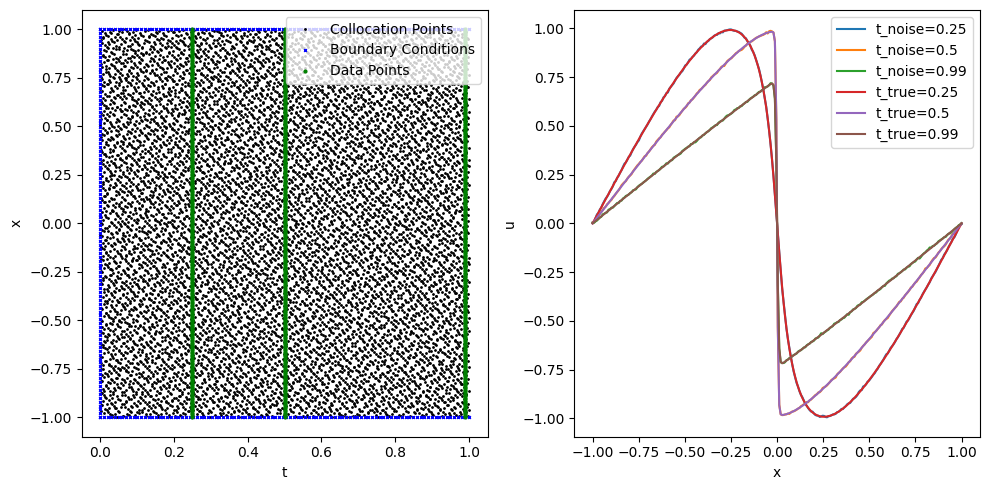

In [49]:
# Plot the initial condition, boundary conditions, and collocation points
ax, fig = plt.subplots(1, 2, figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(Xc[:, 0], Xc[:, 1], 'k.', label='Collocation Points', markersize=2)
plt.plot(Xbc[:, 0], Xbc[:, 1], 'bx', label='Boundary Conditions', markersize=2)
plt.plot(Xd[:, 0], Xd[:, 1], 'go', label='Data Points', markersize=2)
plt.xlabel('t'); plt.ylabel('x'); plt.legend()
plt.subplot(1, 2, 2)
plt.plot(data.x, Ud.reshape(-1, len(time_slices)), label=[f"t_noise={data.t[t][0]}" for t in time_slices])
plt.plot(data.x, data.data_points_noiseless[1].reshape(-1, len(time_slices)), label=[f"t_true={data.t[t][0]}" for t in time_slices])
plt.xlabel('x'); plt.ylabel('u')
plt.legend()
plt.tight_layout()
plt.show()

### Setup Boundary Value Problem

In [50]:
class SparseBurger(torch.nn.Module):
    def __init__(self, nu):
        super(SparseBurger, self).__init__()
        self.nu = nu
    
    def forward(self, X, u):

        d2udxt = torch.autograd.grad(u, X, torch.ones_like(u), create_graph=True)[0]
        u_t = d2udxt[:,0:1]
        u_x = d2udxt[:,1:2]

        u_xx = torch.autograd.grad(d2udxt, X, torch.ones_like(d2udxt), create_graph=True)[0][:,1:2]

        return u_t - self.nu*u_xx

class SparseInviscidBurger(torch.nn.Module):
    def __init__(self, nu):
        super(SparseInviscidBurger, self).__init__()
        self.nu = nu

        self.alpha = torch.nn.Parameter(torch.tensor(0.099))
        self.beta = torch.nn.Parameter(torch.tensor(0.002))
        self.gamma = torch.nn.Parameter(torch.tensor(0.534))
        self.delta = torch.nn.Parameter(torch.tensor(0.070))

    def forward(self, X, u):

        d2udxt = torch.autograd.grad(u, X, torch.ones_like(u), create_graph=True)[0]
        u_t = d2udxt[:,0:1]
        
        return u_t

### Initialize and train UPINN

In [51]:
def F_in(X, U):
    dudxt = torch.autograd.grad(U, X, torch.ones_like(U), create_graph=True)[0]
    u_t = dudxt[:,0:1]
    u_x = dudxt[:,1:2]
    return torch.cat((U, u_t, u_x), dim=-1)

class UPINN(UPINN):

    def refine_collocation_points(self):
        N = 50*N_coll
        D = N_coll
        k = 0.5
        c = 0.1

        Xc = sample_collocation_points(N, 2, lb=[0, -1], ub=[1, 1])
        Xc.requires_grad_(True)

        # Compute the residual
        u = self.u(Xc)
        F_input = F_in(Xc, u)
        residual = abs(self.N(Xc, u) + self.F(F_input))
        
        self.collocation_points = RAD_sampler(Xc, residual, D, k, c)
    
    def score(self):
        return torch.nn.MSELoss()(self.predict(data.data_points_full[0]), data.data_points_full[1]).item()
    
    def score_residual(self):
        z = torch.clone(data.data_points_full[0]).requires_grad_(True)
        u = self.u(z)
        u_x = torch.autograd.grad(u, z, torch.ones_like(u), create_graph=True)[0][:, 1:2]
        return torch.nn.MSELoss()(self.F(F_in(z, u)), -u_x*u).item()


    def F_input(self, X, U):
        dudxt = torch.autograd.grad(U, X, torch.ones_like(U), create_graph=True)[0]
        u_t = dudxt[:,0:1]
        u_x = dudxt[:,1:2]
        return torch.cat((U, u_t, u_x), dim=-1)
    
    def get_loss(self):
        bc_loss = self.bc_loss()
        data_loss = self.data_loss()
        pde_loss = self.pde_loss()
        loss = bc_loss + data_loss + pde_loss
        return loss, bc_loss, data_loss, pde_loss

    def plot(self):
        device = self.device
        self.to('cpu')

        usol = data.usol
        tsol = data.tsol
        xsol = data.xsol


        # Get network prediction
        x_plot = np.linspace(-1, 1, 1000)
        t_plot = np.linspace(0, 1, 1000)
        T, X = np.meshgrid(t_plot, x_plot)
        T_tensor = torch.tensor(T.flatten(), dtype=torch.float32).reshape(-1, 1)
        X_tensor = torch.tensor(X.flatten(), dtype=torch.float32).reshape(-1, 1)
        z_plot = torch.cat((T_tensor, X_tensor), dim=-1)
        z_plot.requires_grad_(True)
        u_pred = self.u(z_plot)

        
        dudz_pred = torch.autograd.grad(u_pred, z_plot, torch.ones_like(u_pred), create_graph=True)[0]
        u_t_pred = dudz_pred[:, 0:1]
        u_x_pred = dudz_pred[:, 1:2]

        res_pred = self.F(torch.cat((u_pred, u_t_pred, u_x_pred), dim=-1))

        # Get the known solution
        dudx = np.gradient(usol, xsol.flatten(), axis=0)

        with torch.no_grad():
            
            u_pred = u_pred.reshape(1000, 1000).detach().numpy()
            u_t_pred = u_t_pred.reshape(1000, 1000).detach().numpy()
            u_x_pred = u_x_pred.reshape(1000, 1000).detach().numpy()
            res_pred = res_pred.reshape(1000, 1000).detach().numpy()

            plt.figure(figsize=(10, 3))

            # Slices of the predicted solution and the known solution
            plt.subplot(1, 2, 1)
            colors = ['b', 'g', 'r', 'c', 'm']  # Define a list of colors for the lines

            plt.plot(x_plot, u_pred[:, 0], label='t=0', color=colors[0])
            plt.plot(x_plot, u_pred[:, 250], label='t=0.25', color=colors[1])
            plt.plot(x_plot, u_pred[:, 500], label='t=0.5', color=colors[2])
            plt.plot(x_plot, u_pred[:, 750], label='t=0.75', color=colors[3])
            plt.plot(x_plot, u_pred[:, 999], label='t=1', color=colors[4])

            plt.plot(xsol, usol[:, 0], '--', color=colors[0])
            plt.plot(xsol, usol[:, 25], '--', color=colors[1])
            plt.plot(xsol, usol[:, 50], '--', color=colors[2])
            plt.plot(xsol, usol[:, 75], '--', color=colors[3])
            plt.plot(xsol, usol[:, 99], '--', color=colors[4])

            plt.xlabel('x'); plt.ylabel('u')
            plt.legend()
            plt.title('Predicted Solution vs. Known Solution')


            # Slices of the predicted residuals and known residuals
            plt.subplot(1, 2, 2)

            plt.plot(x_plot[450:550], res_pred[450:550, 0], label='t=0', color=colors[0])
            plt.plot(x_plot[450:550], res_pred[450:550, 250], label='t=0.25', color=colors[1])
            plt.plot(x_plot[450:550], res_pred[450:550, 500], label='t=0.5', color=colors[2])
            plt.plot(x_plot[450:550], res_pred[450:550, 750], label='t=0.75', color=colors[3])
            plt.plot(x_plot[450:550], res_pred[450:550, 999], label='t=1', color=colors[4])

            plt.plot(xsol[115:140], -dudx[115:140, 0]*usol[115:140, 0], '--', color=colors[0])
            plt.plot(xsol[115:140], -dudx[115:140, 25]*usol[115:140, 25], '--', color=colors[1])
            plt.plot(xsol[115:140], -dudx[115:140, 50]*usol[115:140, 50], '--', color=colors[2])
            plt.plot(xsol[115:140], -dudx[115:140, 75]*usol[115:140, 75], '--', color=colors[3])
            plt.plot(xsol[115:140], -dudx[115:140, 99]*usol[115:140, 99], '--', color=colors[4])

            plt.xlabel('x'); plt.ylabel('Residual')
            plt.legend()
            plt.title('Predicted Residual vs. Known Residual')

            plt.tight_layout()
            plt.show()


            # Find the global vmin and vmax (same for all subplots)
            known_res = -dudx*usol
            exp_res = -u_x_pred*u_pred
            res_err = abs(res_pred - (exp_res))
            res_pred = res_pred

            plt.figure(figsize=(10, 8))

            vmin = min(usol.min(), u_pred.min())
            vmax = max(usol.max(), u_pred.max())
            v = max(abs(vmin), abs(vmax))

            # Known solution
            plt.subplot(3, 2, 1)
            plt.imshow(usol, extent=(0, 1, -1, 1), origin='lower', aspect='auto', vmin=-v, vmax=v)
            plt.xlabel('t'); plt.ylabel('x')
            plt.title('Known Solution')
            plt.colorbar()

            # Predicted solution
            plt.subplot(3, 2, 2)
            plt.imshow(u_pred, extent=(0, 1, -1, 1), origin='lower', aspect='auto', vmin=-v, vmax=v)
            plt.plot(self.collocation_points[:, 0], self.collocation_points[:, 1], 'k.', markersize=.5)
            plt.xlabel('t'); plt.ylabel('x')
            plt.title('Predicted Solution')
            plt.colorbar()

            vmin = min(known_res.min(), exp_res.min(), res_err.min(), res_pred.min())
            vmax = max(known_res.max(), exp_res.max(), res_err.max(), res_pred.max())
            v = max(abs(vmin), abs(vmax))

            # Known residual
            plt.subplot(3, 2, 3)
            plt.imshow(known_res, extent=(0, 1, -1, 1), origin='lower', aspect='auto', vmin=-v, vmax=v)
            plt.xlabel('t'); plt.ylabel('x')
            plt.title('Known Residual')
            plt.colorbar()

            # Predicted residual
            plt.subplot(3, 2, 4)
            plt.imshow(res_pred, extent=(0, 1, -1, 1), origin='lower', aspect='auto', vmin=-v, vmax=v)
            plt.xlabel('t'); plt.ylabel('x')
            plt.title('Predicted Residual')
            plt.colorbar()

            # Expected residual
            plt.subplot(3, 2, 5)
            plt.imshow(exp_res, extent=(0, 1, -1, 1), origin='lower', aspect='auto', vmin=-v, vmax=v)
            plt.xlabel('t'); plt.ylabel('x')
            plt.title('Expected Residual')
            plt.colorbar()

            # Residual error
            plt.subplot(3, 2, 6)
            plt.imshow(res_err, extent=(0, 1, -1, 1), origin='lower', aspect='auto')
            plt.xlabel('t'); plt.ylabel('x')
            plt.title('Residual Error')
            plt.colorbar()

            plt.tight_layout()
            plt.show()
        
        self.to(device)

In [52]:
class FNN_ansatz(FNN):
    def __init__(self, **kwargs):
        super(FNN_ansatz, self).__init__(**kwargs)
    
    def forward(self, X):
        return -torch.sin(torch.pi*X[:, 1:2]) + super(FNN_ansatz, self).forward(X)*(1 - X[:, 1:2])*(1 + X[:, 1:2])*torch.tanh(X[:, 0:1])

In [53]:
hidden = [20] * 8

u = FNN(
    dims=[2, *hidden, 1],
    hidden_act=torch.nn.SiLU(),
    output_act=torch.nn.Identity(),
)

F = FNN(
    dims=[3, *hidden, 1],
    hidden_act=torch.nn.SiLU(),
    output_act=torch.nn.Identity(),
)

nu = 0.01/torch.pi
N = SparseBurger(nu)

# Instantiate the UPINN
upinn = UPINN(u, N, F, boundary_points=(Xbc, Ubc), data_points=data.data_points, collocation_points=Xc)
# upinn = UPINN(u, N, F, boundary_points=(Xbc, Ubc), collocation_points=Xc)

[Info]: Initializing UPINN model


### Alternating optimizers

In [54]:
adamw = torch.optim.AdamW(upinn.parameters(), lr=0.02)
lbfgs = torch.optim.LBFGS(upinn.parameters(), lr=0.1)

for _ in range(1):
    upinn.optimizer = adamw
    upinn.train_loop(1000)
    upinn.optimizer = lbfgs
    upinn.train_loop(500)
    # upinn.refine_collocation_points()
    # upinn.plot()

[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]:   0%|          | 0/1000 [00:00<?, ? epoch/s, L=5.23e-01, L_bc=1.65e-01, L_data=3.58e-01, L_pde=1.47e-07]

[CUDA]: 100%|██████████| 1000/1000 [00:29<00:00, 34.21 epoch/s, L=3.01e-03, L_bc=2.24e-04, L_data=2.27e-03, L_pde=5.15e-04]


[Info]: Training 500 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 500/500 [05:12<00:00,  1.60 epoch/s, L=9.82e-05, L_bc=7.38e-06, L_data=3.69e-05, L_pde=5.40e-05]


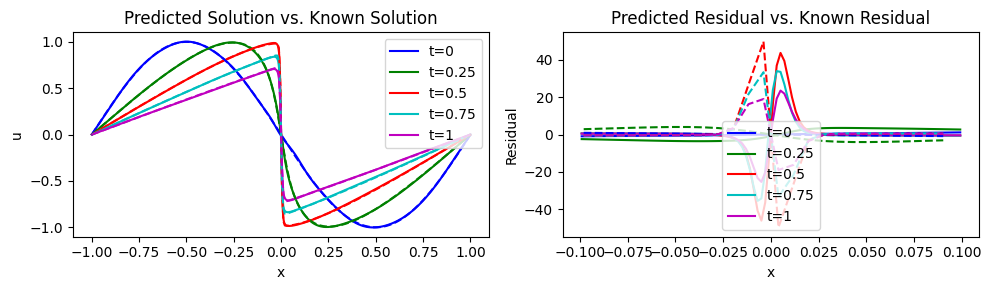

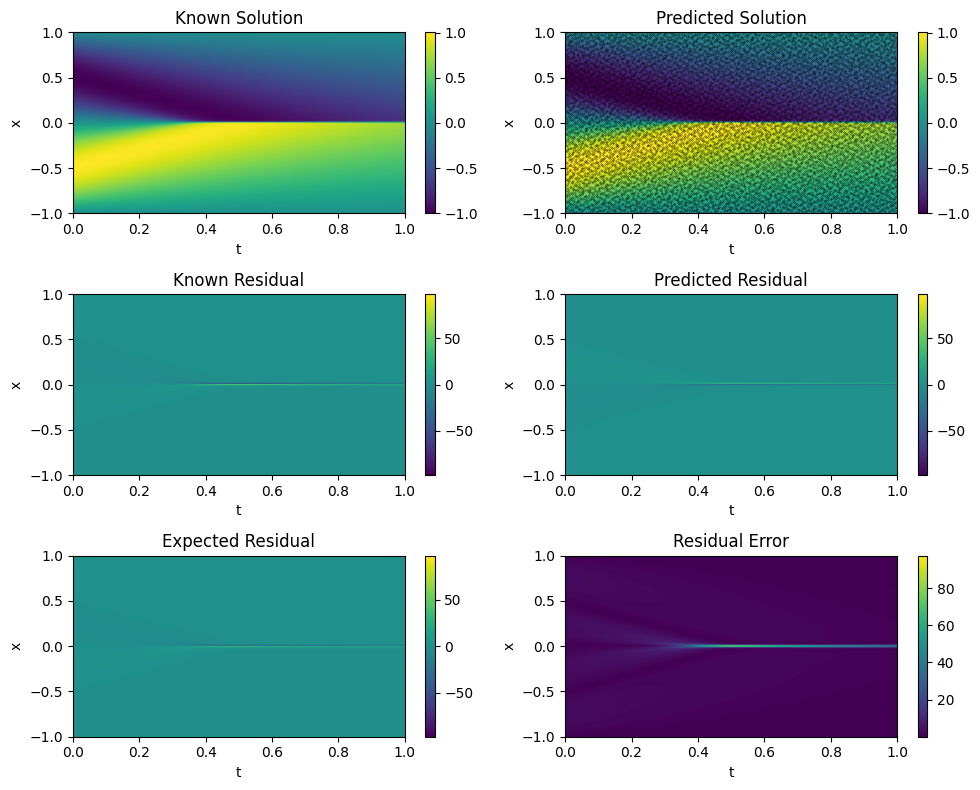

In [55]:
upinn.plot()

### PDE find (SINDy)

In [56]:
import pysindy as ps
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
upinn.to('cpu')

Z_tensor = torch.clone(data.data_points_full[0])
Z_tensor.requires_grad_(True)
U_tensor = upinn.u(Z_tensor)
dUdZ = torch.autograd.grad(U_tensor, Z_tensor, torch.ones_like(U_tensor), create_graph=True)[0]
U_t = dUdZ[:, 0:1]
U_x = dUdZ[:, 1:2]
U_dot_tensor = upinn.F(torch.cat((U_tensor, U_t, U_x), dim=-1))
U_dot = U_dot_tensor.detach().numpy().reshape(*data.original_shape, 1)
U = U_tensor.detach().numpy().reshape(*data.original_shape, 1)
t = data.t.flatten()

train_test_split = 50

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=data.x,
    is_uniform=True,
)

cv_folds = TimeSeriesSplit(n_splits=10)

scores = []
taus = np.logspace(0, 2, 20)
for t_ in taus:
    optimizer = ps.SR3(
        threshold=t_, max_iter=10000, tol=1e-15, thresholder="l1", normalize_columns=True
    )
    model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
    # model.fit(x=U[:, :train_test_split], t=t.flatten()[:train_test_split], x_dot=U_dot[:, :train_test_split])
    # scores.append(model.score(x=U[:, 50:], t=t.flatten()[50:]))
    # if (model.coefficients() != 0).sum() == 0:
    #     break
    cv_scores = []
    for train_idx, test_idx in cv_folds.split(t):
        model.fit(x=U[:, train_idx], t=t[train_idx], x_dot=U_dot[:, train_idx])
        cv_scores.append(model.score(x=U[:, test_idx], t=t[test_idx]))
    scores.append(np.max(cv_scores))

best_t = taus[np.argmin(scores)]

optimizer = ps.SR3(
        threshold=best_t, max_iter=10000, tol=1e-15, thresholder='l1', normalize_columns=True
    )
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
model.fit(x=U[:, :np.max(time_slices)], t=t[:np.max(time_slices)], x_dot=U_dot[:, :np.max(time_slices)])

model.print()
print(upinn.score())
print(upinn.score_residual())

(u)' = 0.001 u_11 + 0.966 uu_1 + -0.005 uuu_11
7.656512025278062e-05
30.30999755859375


In [72]:
optimizer = ps.SR3(
        threshold=50, max_iter=10000, tol=1e-15, thresholder='l1', normalize_columns=True
    )
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
model.fit(x=U, t=t, x_dot=U_dot)

model.print()
print(upinn.score())
print(upinn.score_residual())

(u)' = -0.914 uu_1
7.656512025278062e-05
30.30999755859375


In [58]:
best_t

11.28837891684689

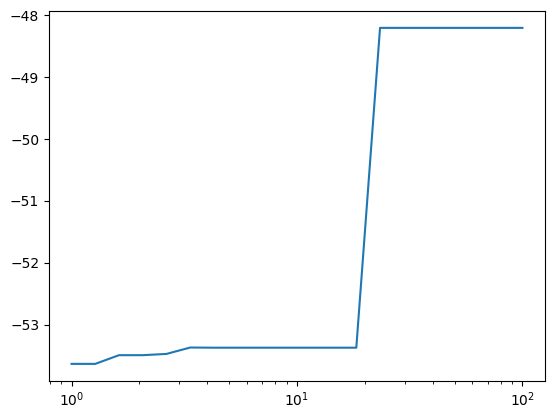

In [69]:
plt.plot(taus, scores)
plt.xscale('log')

In [60]:
scores = []
taus = np.logspace(0, 2, 20)
for t_ in taus:
    optimizer = ps.SR3(
        threshold=t_, max_iter=10000, tol=1e-15, thresholder="l0", normalize_columns=True
    )
    model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
    cv_scores = []
    for train_idx, test_idx in cv_folds.split(t):
        model.fit(x=U[:, train_idx], t=t[train_idx], x_dot=U_dot[:, train_idx])
        cv_scores.append(model.score(x=U[:, test_idx], t=t[test_idx]))
    scores.append(np.mean(cv_scores))

best_t = taus[np.argmin(scores)]

optimizer = ps.SR3(
        threshold=20, max_iter=10000, tol=1e-15, thresholder='l0', normalize_columns=True
    )
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
model.fit(x=U[:, :np.max(time_slices)], t=t[:np.max(time_slices)], x_dot=U_dot[:, :np.max(time_slices)])

model.print()

(u)' = 0.001 u_11 + 0.966 uu_1 + -0.005 uuu_11


In [61]:
optimizer = ps.SR3(
        threshold=179, max_iter=10000, tol=1e-15, thresholder='l0', normalize_columns=True
    )
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
model.fit(x=U[:, :np.max(time_slices)], t=t[:np.max(time_slices)], x_dot=U_dot[:, :np.max(time_slices)])

model.print()

(u)' = 0.913 uu_1


In [62]:
scores = []
taus = np.logspace(0, 2, 20)
for t_ in taus:
    optimizer = ps.SR3(
        threshold=t_, max_iter=10000, tol=1e-15, thresholder="l1", normalize_columns=True
    )
    model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
    cv_scores = []
    for train_idx, test_idx in cv_folds.split(t):
        model.fit(x=U[:, train_idx], t=t[train_idx], x_dot=U_dot[:, train_idx])
        cv_scores.append(model.score(x=U[:, test_idx], t=t[test_idx]))
    scores.append(np.mean(cv_scores))

best_t = taus[np.argmin(scores)]

optimizer = ps.SR3(
        threshold=best_t, max_iter=10000, tol=1e-15, thresholder='l1', normalize_columns=True
    )
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
model.fit(x=U[:, :np.max(time_slices)], t=t[:np.max(time_slices)], x_dot=U_dot[:, :np.max(time_slices)])

model.print()

(u)' = 0.001 u_11 + 0.966 uu_1 + -0.005 uuu_11


In [63]:
scores = []
taus = np.logspace(0, 2, 20)
for t_ in taus:
    optimizer = ps.STLSQ(
        threshold=t_, alpha=1e-5, normalize_columns=True
    )
    model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
    cv_scores = []
    for train_idx, test_idx in cv_folds.split(t):
        model.fit(x=U[:, train_idx], t=t[train_idx], x_dot=U_dot[:, train_idx])
        cv_scores.append(model.score(x=U[:, test_idx], t=t[test_idx]))
    scores.append(np.mean(cv_scores))

best_t = taus[np.argmin(scores)]

optimizer = ps.STLSQ(
        threshold=best_t, alpha=1e-5, normalize_columns=True
    )
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
model.fit(x=U[:, :np.max(time_slices)], t=t[:np.max(time_slices)], x_dot=U_dot[:, :np.max(time_slices)])

model.print()
print(upinn.score())
print(upinn.score_residual())

(u)' = 0.001 u_11 + 0.966 uu_1 + -0.005 uuu_11
7.656512025278062e-05
30.30999755859375


In [64]:
scores = []
taus = np.logspace(0, 2, 20)
for t_ in taus:
    optimizer = ps.SSR(
        normalize_columns=True, alpha=0.00001
    )
    model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
    cv_scores = []
    for train_idx, test_idx in cv_folds.split(t):
        model.fit(x=U[:, train_idx], t=t[train_idx], x_dot=U_dot[:, train_idx])
        cv_scores.append(model.score(x=U[:, test_idx], t=t[test_idx]))
    scores.append(np.mean(cv_scores))

best_t = taus[np.argmin(scores)]

optimizer = ps.SSR(
        normalize_columns=True
    )
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
model.fit(x=U[:, :np.max(time_slices)], t=t[:np.max(time_slices)], x_dot=U_dot[:, :np.max(time_slices)])

model.print()
print(upinn.score())
print(upinn.score_residual())

(u)' = 0.032 u + 0.013 uu + 0.019 u_1 + 0.001 u_11 + 0.960 uu_1 + -0.046 uuu_1 + -0.005 uuu_11
7.656512025278062e-05
30.30999755859375
